In [12]:
import os
from pathlib import Path

# 1. Dove si trova il notebook adesso?
current_dir = Path.cwd()
print(f"📍 Cartella attuale del Notebook: {current_dir}")

# 2. Proviamo a costruire il path come dici tu (togliendo 'gen')
# Se sei dentro 'gen', il path dovrebbe iniziare con 'wikipedia'
target_path = current_dir / "wikipedia/experiments/run_20251126_092646/results"

print(f"\n🔍 Cerco in: {target_path}")

if target_path.exists():
    print("✅ Cartella trovata!")
    print("Files contenuti:", os.listdir(target_path))
else:
    print("❌ Cartella NON trovata.")
    
    # 3. Aiuto: vediamo cosa c'è nella cartella attuale per capire dove andare
    print(f"\n📂 Contenuto della cartella attuale ({current_dir.name}):")
    print(os.listdir(current_dir))

📍 Cartella attuale del Notebook: C:\Users\Giuly\UNI\magistrale\TESI\codice\gen

🔍 Cerco in: C:\Users\Giuly\UNI\magistrale\TESI\codice\gen\wikipedia\experiments\run_20251126_092646\results
✅ Cartella trovata!
Files contenuti: ['contextual_GLOBAL.csv', 'contextual_SUFFIX.csv', 'counterfactual_GLOBAL.csv', 'counterfactual_SUFFIX.csv', 'experiment_config.txt']


In [15]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ------------------------------------------------------------------------------
# 1. PLOTTING STYLE (Academic/Thesis Style)
# ------------------------------------------------------------------------------
plt.rcParams["font.family"] = "serif"
sns.set(rc={"font.size":12, "axes.titlesize":14, "axes.labelsize":12, 
            "ytick.labelsize":10, "xtick.labelsize":10}, style="whitegrid")

# ------------------------------------------------------------------------------
# 2. PATH CONFIGURATION
# ------------------------------------------------------------------------------
# Base path to your specific experiment run
BASE_PATH = Path("wikipedia/experiments/run_20251126_092646")

# Sub-directories
RESULTS_DIR = BASE_PATH / "results"       # Contains CSVs (Contextual/Counterfactual)
MIA_LOG_DIR = BASE_PATH / "M_noC"         # Contains stdout for MIA Recall

print(f"📂 Working Directory: {os.getcwd()}")
print(f"📂 Base Path: {BASE_PATH}")

📂 Working Directory: C:\Users\Giuly\UNI\magistrale\TESI\codice\gen
📂 Base Path: wikipedia\experiments\run_20251126_092646


In [16]:
def extract_frequency(canary_id):
    """
    Extracts repetition count from canary ID (e.g., 'HighEnt_rep100_0' -> 100).
    """
    match = re.search(r'rep(\d+)_', str(canary_id))
    if match:
        return int(match.group(1))
    return 0

def load_ghosh_metrics(results_dir):
    """
    Loads Contextual/Counterfactual CSV files and merges them into one DataFrame.
    """
    files_map = {
        'Contextual_Global': 'contextual_GLOBAL.csv',
        'Contextual_Suffix': 'contextual_SUFFIX.csv',
        'Counterfactual_Global': 'counterfactual_GLOBAL.csv',
        'Counterfactual_Suffix': 'counterfactual_SUFFIX.csv'
    }
    
    dfs = []
    
    for metric_key, filename in files_map.items():
        file_path = results_dir / filename
        
        if not file_path.exists():
            print(f"⚠️ File not found: {filename} (Skipping)")
            continue
            
        # Read CSV
        df_temp = pd.read_csv(file_path)
        
        # Add Metadata columns
        parts = metric_key.split('_')
        df_temp['Metric_Family'] = parts[0]  # Contextual or Counterfactual
        df_temp['Loss_Type'] = parts[1]      # Global or Suffix
        df_temp['Full_Metric_Name'] = metric_key
        
        # Extract frequency
        df_temp['Frequency'] = df_temp['canary_id'].apply(extract_frequency)
        
        dfs.append(df_temp)
    
    if not dfs:
        raise FileNotFoundError(f"No CSV files found in {results_dir}")
        
    # Concatenate
    df_final = pd.concat(dfs, ignore_index=True)
    
    # Convert Frequency to Categorical for correct plotting order
    freqs = sorted(df_final['Frequency'].unique())
    df_final['Frequency'] = pd.Categorical(df_final['Frequency'], categories=freqs, ordered=True)
    
    return df_final

# --- EXECUTION ---
try:
    df_mem = load_ghosh_metrics(RESULTS_DIR)
    print(f"✅ Successfully loaded {len(df_mem)} rows of memorization data.")
    display(df_mem.head())
except Exception as e:
    print(f"❌ Error loading CSVs: {e}")

✅ Successfully loaded 800 rows of memorization data.


,epoch,canary_id,score,start_epoch,opt_ctx_loss,Metric_Family,Loss_Type,Full_Metric_Name,Frequency
0,0,HighEnt_rep100_0,0.882543,0,5.236588,Contextual,Global,Contextual_Global,100
1,0,HighEnt_rep100_1,0.907635,0,5.204485,Contextual,Global,Contextual_Global,100
2,0,HighEnt_rep100_2,0.893308,0,5.624913,Contextual,Global,Contextual_Global,100
3,0,HighEnt_rep100_3,0.878796,0,5.463252,Contextual,Global,Contextual_Global,100
4,0,HighEnt_rep100_4,0.837698,0,4.681811,Contextual,Global,Contextual_Global,100


💾 Plot saved to: wikipedia\experiments\run_20251126_092646\results\plot_dynamics_Counterfactual_Suffix.pdf


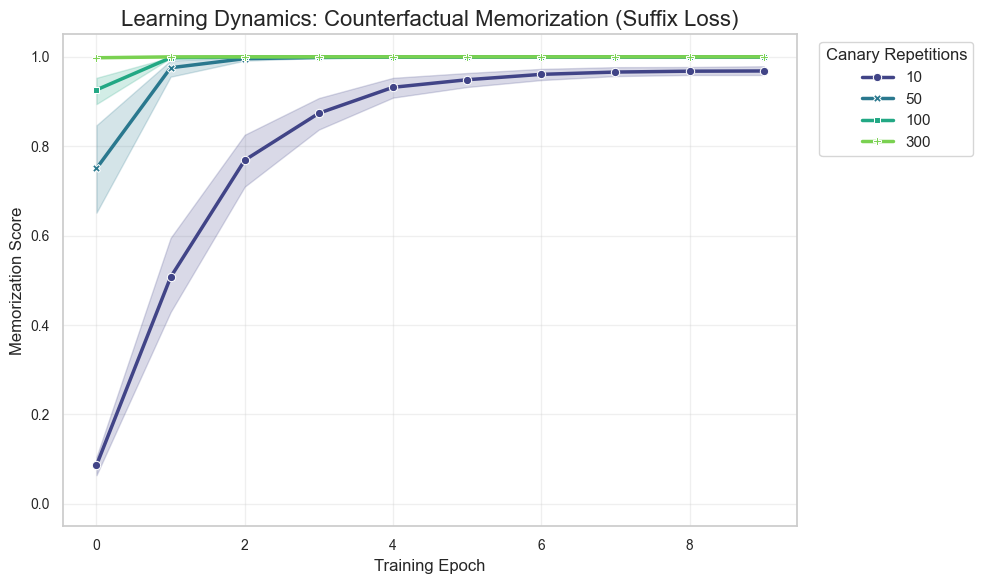

In [17]:
def plot_learning_dynamics(df, metric_family='Counterfactual', loss_type='Suffix'):
    """
    Plots score evolution over epochs using line plots.
    """
    # Filter data
    mask = (df['Metric_Family'] == metric_family) & (df['Loss_Type'] == loss_type)
    data_plot = df[mask]
    
    if data_plot.empty:
        print(f"⚠️ No data found for {metric_family} - {loss_type}")
        return

    plt.figure(figsize=(10, 6))
    
    # Lineplot with CI
    sns.lineplot(
        data=data_plot,
        x='epoch',
        y='score',
        hue='Frequency',
        style='Frequency',
        markers=True,
        dashes=False,
        palette='viridis',
        linewidth=2.5
    )
    
    plt.title(f"Learning Dynamics: {metric_family} Memorization ({loss_type} Loss)", fontsize=16)
    plt.xlabel("Training Epoch", fontsize=12)
    plt.ylabel("Memorization Score", fontsize=12)
    plt.ylim(-0.05, 1.05)
    plt.legend(title="Canary Repetitions", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save
    filename = RESULTS_DIR / f"plot_dynamics_{metric_family}_{loss_type}.pdf"
    plt.savefig(filename)
    print(f"💾 Plot saved to: {filename}")
    plt.show()

# Generate Plot
plot_learning_dynamics(df_mem, metric_family='Counterfactual', loss_type='Suffix')

💾 Plot saved to: wikipedia\experiments\run_20251126_092646\results\plot_global_vs_suffix.pdf


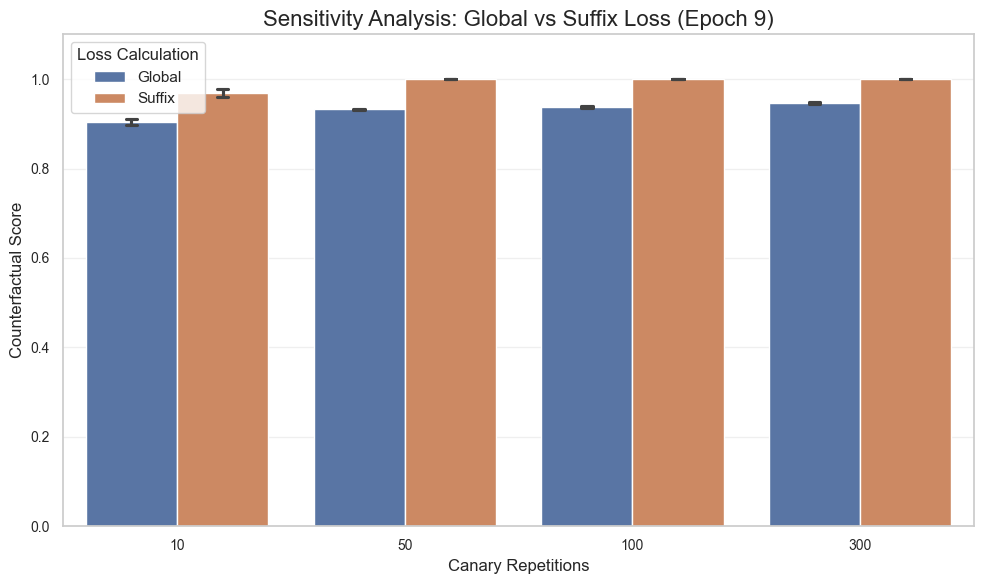

In [18]:
def plot_loss_comparison(df, target_epoch=None):
    """
    Compares Global vs Suffix loss scores at a specific epoch.
    """
    # If no epoch specified, take the max
    if target_epoch is None:
        target_epoch = df['epoch'].max()
        
    # Filter: Counterfactual is usually the best baseline for this comparison
    mask = (df['epoch'] == target_epoch) & (df['Metric_Family'] == 'Counterfactual')
    data_plot = df[mask]
    
    plt.figure(figsize=(10, 6))
    
    # Barplot
    sns.barplot(
        data=data_plot,
        x='Frequency',
        y='score',
        hue='Loss_Type',
        palette='deep',
        errorbar=('ci', 95),
        capsize=.1
    )
    
    plt.title(f"Sensitivity Analysis: Global vs Suffix Loss (Epoch {target_epoch})", fontsize=16)
    plt.xlabel("Canary Repetitions", fontsize=12)
    plt.ylabel("Counterfactual Score", fontsize=12)
    plt.ylim(0, 1.1)
    plt.legend(title="Loss Calculation")
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    # Save
    filename = RESULTS_DIR / "plot_global_vs_suffix.pdf"
    plt.savefig(filename)
    print(f"💾 Plot saved to: {filename}")
    plt.show()

# Generate Plot
plot_loss_comparison(df_mem)

MIA

In [20]:
import re
import pandas as pd

def find_stdout_file(base_dir):
    """
    Searches for the 'stdout' file recursively inside the given directory.
    Returns the path of the first match found.
    """
    # Search for any file named 'stdout' inside M_noC and its subfolders
    found_files = list(base_dir.rglob("stdout"))
    
    if not found_files:
        return None
    
    # Return the first one found (usually there is only one per run)
    return found_files[0]

def parse_mia_log(file_path):
    """
    Parses the stdout log file to extract Epoch and MIA Recall (ratio).
    Splits by 'training epoch' to handle multi-line logs.
    """
    data = []
    
    # Regex Patterns
    epoch_pattern = re.compile(r"(\d+)")
    ratio_pattern = re.compile(r"ratio is:\s+(\d+\.\d+)")
    
    try:
        with open(file_path, 'r') as f:
            content = f.read()
            
        # Split content by "training epoch "
        # This creates chunks of text, each belonging to a specific epoch
        blocks = content.split('training epoch ')
        
        for block in blocks:
            # Skip empty blocks or header info
            if not block.strip():
                continue
                
            # Look for the epoch number at the start of the block
            # The split consumes "training epoch ", so the block usually starts with the number
            # e.g., "0\n*************end..."
            epoch_match = epoch_pattern.match(block.strip())
            
            # Look for the ratio anywhere in the block
            ratio_match = ratio_pattern.search(block)
            
            if epoch_match and ratio_match:
                ep = int(epoch_match.group(1))
                score = float(ratio_match.group(1))
                
                data.append({
                    'epoch': ep,
                    'MIA_Score': score
                })
                
    except Exception as e:
        print(f"⚠️ Error parsing file: {e}")
        return pd.DataFrame()
        
    return pd.DataFrame(data)

# --- EXECUTION ---

# 1. Find the file automatically
mia_file = find_stdout_file(MIA_LOG_DIR)

if mia_file:
    print(f"✅ Found MIA log file at:\n   {mia_file}")
    
    # 2. Parse the file
    df_mia = parse_mia_log(mia_file)

    if not df_mia.empty:
        print(f"\n✅ Successfully loaded MIA Data for {len(df_mia)} epochs.")
        display(df_mia)
    else:
        print("❌ File found but no data parsed. Check regex patterns.")
else:
    print(f"❌ 'stdout' file not found inside: {MIA_LOG_DIR}")
    print("   Check if the folder structure matches the path configuration.")

✅ Found MIA log file at:
   wikipedia\experiments\run_20251126_092646\M_noC\canary_None_5_adapter_False_head_False_layer_None_ref_False_maxlen_1024_red_None_model_gpt2_lr_5e-05_epoch_10_trba_1_acc_8_evba1_data_wikitext\stdout

✅ Successfully loaded MIA Data for 10 epochs.


,epoch,MIA_Score
0,0,0.177739
1,1,0.245039
2,2,0.316652
3,3,0.374461
4,4,0.430975
5,5,0.492666
6,6,0.526316
7,7,0.564280
8,8,0.584987
9,9,0.588438


💾 Plot saved to: wikipedia\experiments\run_20251126_092646\results\plot_correlation_MIA_vs_Contextual.pdf


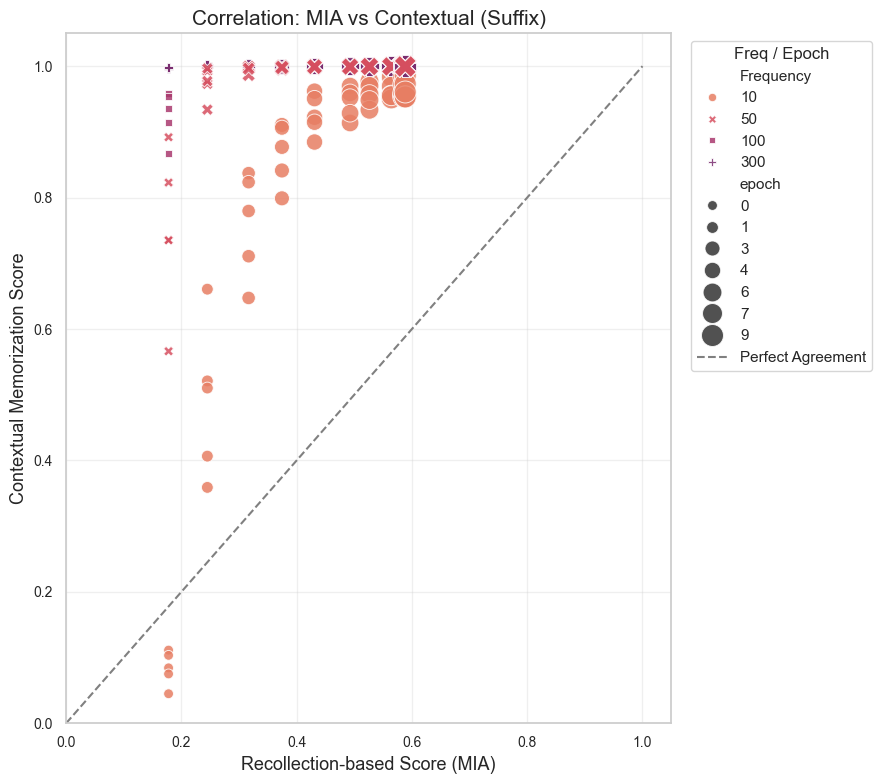

In [21]:
def plot_metric_correlation(df_mem, df_mia, y_metric_family='Contextual', y_loss_type='Suffix'):
    """
    Scatter plot correlating MIA (Recollection) vs New Metrics.
    """
    # 1. Prepare Data: Filter the specific metric from Ghosh results
    mask = (df_mem['Metric_Family'] == y_metric_family) & (df_mem['Loss_Type'] == y_loss_type)
    df_y = df_mem[mask].copy()
    
    if df_y.empty or df_mia.empty:
        print("⚠️ Missing data for correlation plot.")
        return

    # 2. Merge: Associate MIA score of the epoch to all canaries of that epoch
    merged_df = pd.merge(df_y, df_mia, on='epoch', how='inner')

    plt.figure(figsize=(9, 8))
    
    # 3. Plot
    sns.scatterplot(
        data=merged_df,
        x='MIA_Score',
        y='score',
        hue='Frequency',
        style='Frequency',
        size='epoch',
        sizes=(50, 250),
        palette='flare',
        alpha=0.85,
        edgecolor='w'
    )
    
    # 4. Diagonal Reference Line (y=x)
    # Points below line = MIA overestimates compared to Contextual
    plt.plot([0, 1], [0, 1], ls="--", c="gray", label="Perfect Agreement")
    
    plt.title(f"Correlation: MIA vs {y_metric_family} ({y_loss_type})", fontsize=15)
    plt.xlabel("Recollection-based Score (MIA)", fontsize=13)
    plt.ylabel(f"{y_metric_family} Memorization Score", fontsize=13)
    plt.xlim(0, 1.05)
    plt.ylim(0, 1.05)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="Freq / Epoch")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save
    filename = RESULTS_DIR / f"plot_correlation_MIA_vs_{y_metric_family}.pdf"
    plt.savefig(filename)
    print(f"💾 Plot saved to: {filename}")
    plt.show()

# Execute Comparison
# Contextual is usually much stricter than MIA
plot_metric_correlation(df_mem, df_mia, y_metric_family='Contextual', y_loss_type='Suffix')

💾 Plot saved to: wikipedia\experiments\run_20251126_092646\results\plot_hierarchy_Suffix.pdf


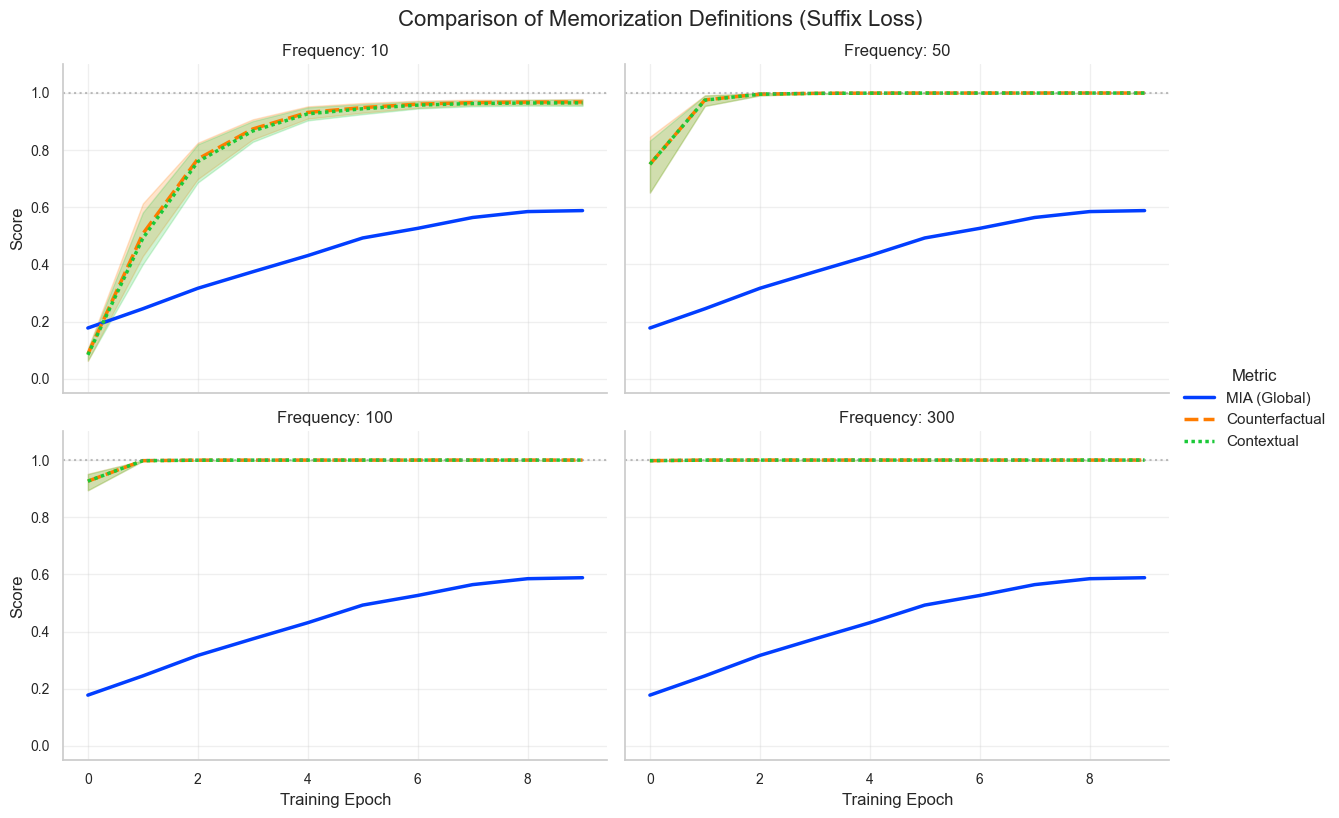

In [25]:
def plot_memorization_hierarchy(df_ghosh, df_mia, loss_type='Suffix'):
    """
    Plots the three metrics side-by-side to visualize the hierarchy:
    1. MIA (Recollection-based) [Global Baseline]
    2. Counterfactual [Canary-specific]
    3. Contextual [Canary-specific, strictest]
    """
    
    # 1. Prepare Ghosh Data (Contextual & Counterfactual)
    # Filter for the specific loss type
    mask = df_ghosh['Loss_Type'] == loss_type
    df_subset = df_ghosh[mask].copy()
    
    # Select columns and rename
    df_plot_ghosh = df_subset[['epoch', 'Frequency', 'Metric_Family', 'score']].copy()
    df_plot_ghosh.rename(columns={'Metric_Family': 'Metric', 'score': 'Score'}, inplace=True)
    
    # 2. Prepare MIA Data (Global Baseline)
    # We replicate the global MIA score for each frequency to allow comparison in panels
    frequencies = df_plot_ghosh['Frequency'].unique()
    mia_rows = []
    
    if not df_mia.empty:
        for _, row in df_mia.iterrows():
            for freq in frequencies:
                mia_rows.append({
                    'epoch': row['epoch'],
                    'Frequency': freq,
                    'Metric': 'MIA (Global)', # Explicitly mark as Global
                    'Score': row['MIA_Score']
                })
    
    df_plot_mia = pd.DataFrame(mia_rows)
    
    # 3. Combine All Data
    df_final = pd.concat([df_plot_ghosh, df_plot_mia], ignore_index=True)
    
    # 4. Define Order and Colors
    # We want to highlight the difference between the three
    metric_order = ['MIA (Global)', 'Counterfactual', 'Contextual']
    
    # Custom palette: Green (MIA), Orange (CF), Blue (Ctx)
    custom_palette = sns.color_palette("Set1", 3) 

    # 5. Generate Plot
    g = sns.relplot(
        data=df_final,
        x="epoch", 
        y="Score",
        hue="Metric",
        style="Metric",
        col="Frequency",
        col_wrap=2,
        kind="line",
        height=4,
        aspect=1.5,
        linewidth=2.5,
        hue_order=metric_order,
        style_order=metric_order,
        palette="bright" # Bright colors to distinguish lines
    )

    # 6. Styling
    g.fig.suptitle(f"Comparison of Memorization Definitions ({loss_type} Loss)", y=1.02, fontsize=16)
    g.set_titles("Frequency: {col_name}")
    g.set_axis_labels("Training Epoch", "Score")
    
    for ax in g.axes.flat:
        ax.set_ylim(-0.05, 1.1)
        ax.axhline(1.0, ls=':', color='gray', alpha=0.5)
        ax.grid(True, alpha=0.3)

    # 7. Save
    filename = RESULTS_DIR / f"plot_hierarchy_{loss_type}.pdf"
    plt.savefig(filename, bbox_inches='tight')
    print(f"💾 Plot saved to: {filename}")
    plt.show()

# --- EXECUTE ---
if 'df_mem' in locals() and 'df_mia' in locals():
    plot_memorization_hierarchy(df_mem, df_mia, loss_type='Suffix')
else:
    print("⚠️ Data not loaded. Please run previous cells.")

💾 Plot saved to: wikipedia\experiments\run_20251126_092646\results\comparison_global_loss_divergence.pdf


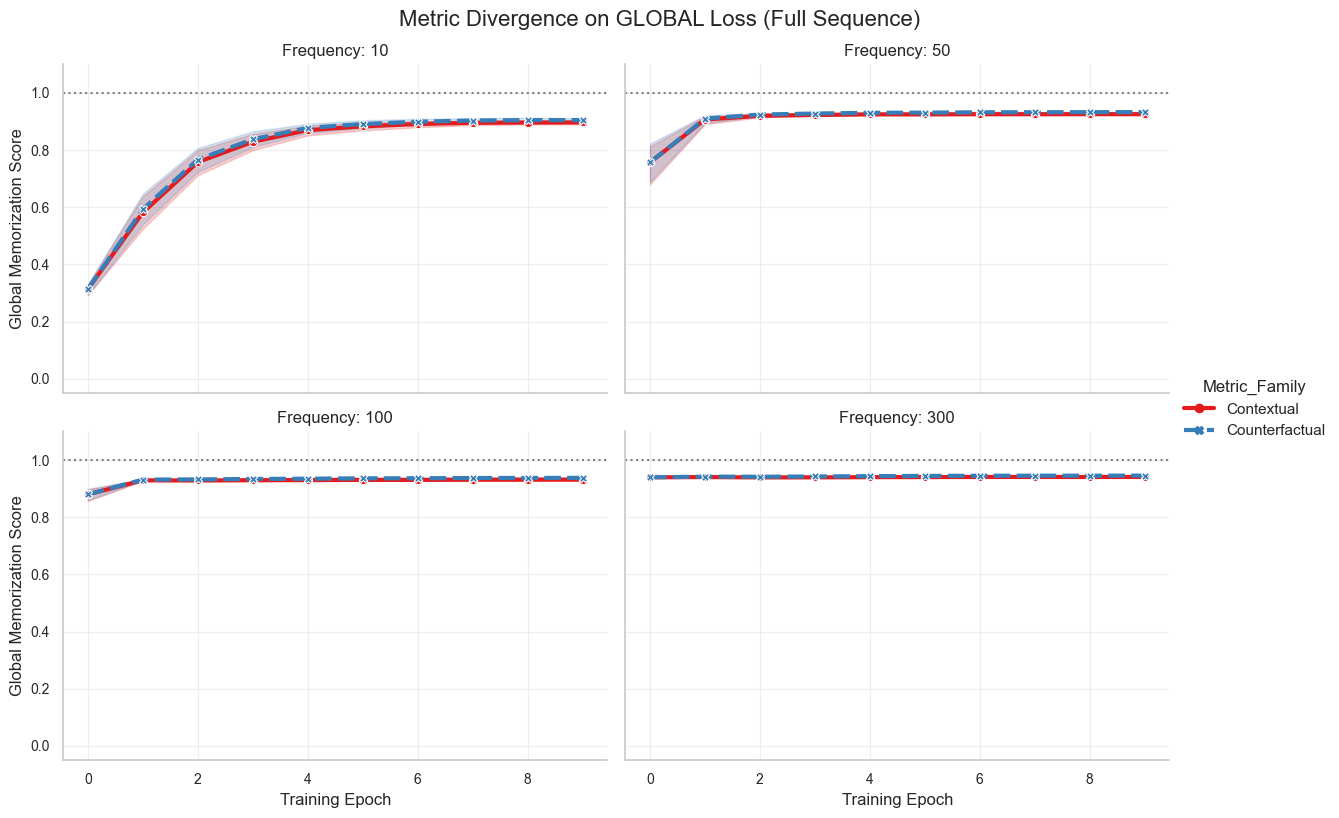

In [26]:
def plot_global_loss_comparison(df):
    """
    Plots a direct comparison between Counterfactual and Contextual scores 
    using GLOBAL Loss (entire sequence including prefix).
    
    Hypothesis: Global loss includes the predictable prefix. Counterfactual might 
    overestimate memorization due to prefix learning, while Contextual should 
    theoretically discount it better.
    """
    
    # 1. Filter Data for GLOBAL Loss
    mask = df['Loss_Type'] == 'Global'
    data_plot = df[mask].copy()
    
    if data_plot.empty:
        print("⚠️ No Global Loss data found.")
        return

    # 2. Create FacetGrid Plot
    g = sns.relplot(
        data=data_plot,
        x="epoch", 
        y="score",
        hue="Metric_Family",   # Compare Contextual vs Counterfactual
        style="Metric_Family",
        col="Frequency",       # One panel per frequency
        col_wrap=2,
        kind="line",
        height=4,
        aspect=1.5,
        linewidth=3,
        palette="Set1",        # Distinct colors (Red vs Blue)
        markers=True
    )

    # 3. Styling
    g.fig.suptitle("Metric Divergence on GLOBAL Loss (Full Sequence)", y=1.02, fontsize=16)
    g.set_titles("Frequency: {col_name}")
    g.set_axis_labels("Training Epoch", "Global Memorization Score")
    
    # Customize axes
    for ax in g.axes.flat:
        ax.set_ylim(-0.05, 1.1)
        ax.grid(True, alpha=0.3)
        # Reference line at 1.0
        ax.axhline(1.0, ls=':', color='gray')

    # 4. Save
    filename = RESULTS_DIR / "comparison_global_loss_divergence.pdf"
    plt.savefig(filename, bbox_inches='tight')
    print(f"💾 Plot saved to: {filename}")
    plt.show()

# Execute
plot_global_loss_comparison(df_mem)

Analyzing log file: stdout
DEBUG: Found 11 blocks in log file.
✅ Extracted Thresholds for 10 epochs.
   (First 3 thresholds: {0: 2.7582550048828125, 1: 2.7418363094329834, 2: 2.733475923538208})

🔍 DEBUG: Checking values for epoch 1, Freq 100:
   Ref Loss: nan | FT Loss: nan | Diff: nan
   Threshold: 2.7418 | Memorized? False


C:\Users\Giuly\AppData\Local\Temp\ipykernel_39772\1549338166.py:86: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mia_recall = df_calc.groupby(['epoch', 'Frequency'])['Canary_MIA_Decision'].mean().reset_index()


💾 Plot saved to: wikipedia\experiments\run_20251126_092646\results\plot_canary_specific_mia_vs_ctx.pdf


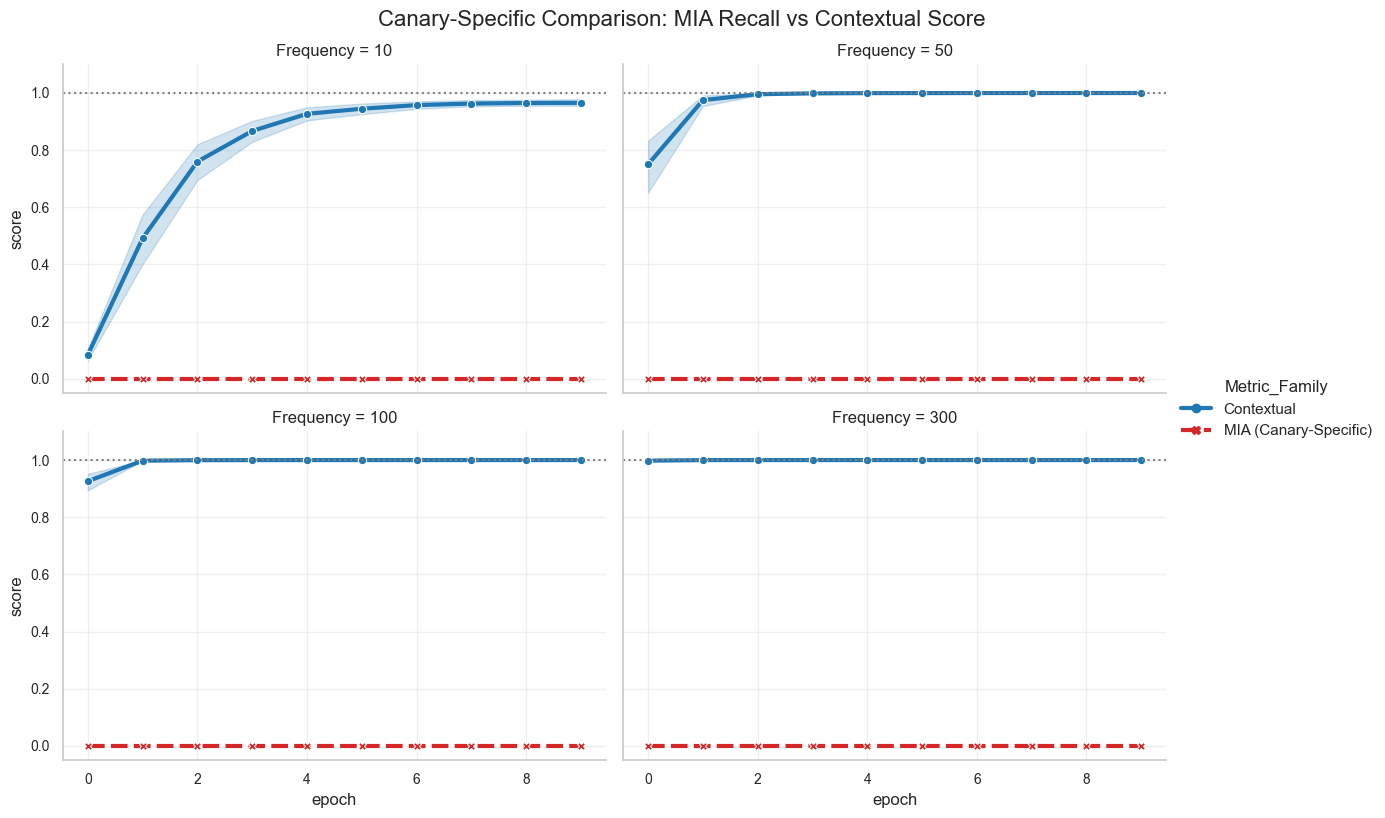

In [31]:
def get_epoch_thresholds(log_path):
    """
    Parses the stdout log to extract the specific MIA Threshold used at each epoch.
    """
    thresholds = {}
    
    # Regex to find threshold (e.g., "threshold is:  2.758...")
    thresh_pattern = re.compile(r"threshold is:\s+(\d+\.\d+)")
    
    # Regex to find epoch number at the start of the block (just digits)
    epoch_pattern = re.compile(r"^(\d+)")
    
    try:
        with open(log_path, 'r') as f:
            content = f.read()
            
            # Split content by "training epoch "
            # This removes the phrase "training epoch " leaving just the number at start
            blocks = content.split('training epoch ')
            
            print(f"DEBUG: Found {len(blocks)} blocks in log file.")
            
            for i, block in enumerate(blocks):
                block = block.strip()
                if not block: continue
                
                # Look for epoch number at the very start of the block
                ep_match = epoch_pattern.match(block)
                
                # Look for threshold anywhere in the block
                th_match = thresh_pattern.search(block)
                
                if ep_match and th_match:
                    epoch = int(ep_match.group(1))
                    threshold = float(th_match.group(1))
                    thresholds[epoch] = threshold
                    # print(f"  -> Epoch {epoch}: Threshold {threshold}") # Uncomment to see details
                elif i > 0: # Skip index 0 which is usually header
                    print(f"  -> Warning: Block {i} missing data. Epoch found? {bool(ep_match)}, Threshold found? {bool(th_match)}")

    except Exception as e:
        print(f"⚠️ Error reading thresholds: {e}")
        
    return thresholds

def calculate_canary_mia(df_ghosh, thresholds_map):
    """
    Applies the MIA threshold based on LOSS DIFFERENCE (Likelihood Ratio in log space).
    
    Hypothesis: The threshold (approx 2.7) represents the improvement in loss 
    required to classify a sample as 'member'.
    """
    # Filter for Counterfactual Suffix
    mask = (df_ghosh['Metric_Family'] == 'Counterfactual') & (df_ghosh['Loss_Type'] == 'Suffix')
    df_calc = df_ghosh[mask].copy()
    
    # 1. Reconstruct Loss of Finetuned Model
    # score = 1 - (Loss_ft / Loss_ref)  -> Loss_ft = Loss_ref * (1 - score)
    df_calc['Loss_FT'] = df_calc['opt_ctx_loss'] * (1 - df_calc['score'])
    
    # 2. Calculate the Score as the DIFFERENCE (Gain)
    # This is equivalent to Log-Likelihood Ratio
    df_calc['MIA_Score_Value'] = df_calc['opt_ctx_loss'] - df_calc['Loss_FT']
    
    # Debug: Print a few examples to check values
    print("\n🔍 DEBUG: Checking values for epoch 1, Freq 100:")
    sample = df_calc[(df_calc['epoch'] == 1) & (df_calc['Frequency'] == 100)].head(1)
    if not sample.empty:
        ref = sample['opt_ctx_loss'].values[0]
        ft = sample['Loss_FT'].values[0]
        diff = sample['MIA_Score_Value'].values[0]
        t = thresholds_map.get(1, 0)
        print(f"   Ref Loss: {ref:.4f} | FT Loss: {ft:.4f} | Diff: {diff:.4f}")
        print(f"   Threshold: {t:.4f} | Memorized? {diff > t}")

    # 3. Apply Threshold
    def apply_threshold(row):
        t = thresholds_map.get(row['epoch'])
        if t is None: return 0.0
        # If the improvement (Diff) is greater than threshold -> Member
        return 1.0 if row['MIA_Score_Value'] > t else 0.0

    df_calc['Canary_MIA_Decision'] = df_calc.apply(apply_threshold, axis=1)
    
    # Calculate Recall
    mia_recall = df_calc.groupby(['epoch', 'Frequency'])['Canary_MIA_Decision'].mean().reset_index()
    mia_recall.rename(columns={'Canary_MIA_Decision': 'score'}, inplace=True)
    mia_recall['Metric_Family'] = 'MIA (Canary-Specific)'
    
    return mia_recall

def plot_canary_comparison(df_ghosh, df_mia_canary, loss_type='Suffix'):
    """
    Plots Contextual vs the Calculated Canary-MIA.
    """
    # Get Contextual Data
    mask = (df_ghosh['Metric_Family'] == 'Contextual') & (df_ghosh['Loss_Type'] == loss_type)
    df_ctx = df_ghosh[mask][['epoch', 'Frequency', 'Metric_Family', 'score']].copy()
    
    # Combine
    df_final = pd.concat([df_ctx, df_mia_canary], ignore_index=True)
    
    # Plot
    g = sns.relplot(
        data=df_final,
        x="epoch", y="score",
        hue="Metric_Family", style="Metric_Family",
        col="Frequency", col_wrap=2,
        kind="line", height=4, aspect=1.5,
        linewidth=3, markers=True,
        palette=["#1f77b4", "#d62728"] # Blue vs Red
    )
    
    g.fig.suptitle(f"Canary-Specific Comparison: MIA Recall vs Contextual Score", y=1.02, fontsize=16)
    
    for ax in g.axes.flat:
        ax.set_ylim(-0.05, 1.1)
        ax.axhline(1.0, ls=':', color='gray')
        ax.grid(True, alpha=0.3)
        
    filename = RESULTS_DIR / "plot_canary_specific_mia_vs_ctx.pdf"
    plt.savefig(filename, bbox_inches='tight')
    print(f"💾 Plot saved to: {filename}")
    plt.show()

# --- EXECUTE ---
stdout_file = find_stdout_file(MIA_LOG_DIR) 

if stdout_file:
    print(f"Analyzing log file: {stdout_file.name}")
    thresholds = get_epoch_thresholds(stdout_file)
    
    if thresholds:
        print(f"✅ Extracted Thresholds for {len(thresholds)} epochs.")
        print(f"   (First 3 thresholds: {dict(list(thresholds.items())[:3])})")
        
        # 2. Calculate Canary MIA
        df_mia_canary = calculate_canary_mia(df_mem, thresholds)
        
        # 3. Plot
        plot_canary_comparison(df_mem, df_mia_canary, loss_type='Suffix')
    else:
        print("⚠️ No thresholds found. Check the file content or regex.")
else:
    print("❌ stdout file not found.")

🚀 Recalculating MIA with Loss Difference Logic...

🔍 DEBUG: Checking values for epoch 1, Freq 100:
   Ref Loss: nan | FT Loss: nan | Diff: nan
   Threshold: 2.7418 | Memorized? False
   Max MIA Recall found: 0.0


C:\Users\Giuly\AppData\Local\Temp\ipykernel_39772\1549338166.py:86: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mia_recall = df_calc.groupby(['epoch', 'Frequency'])['Canary_MIA_Decision'].mean().reset_index()


💾 Plot saved to: wikipedia\experiments\run_20251126_092646\results\plot_canary_specific_mia_vs_ctx.pdf


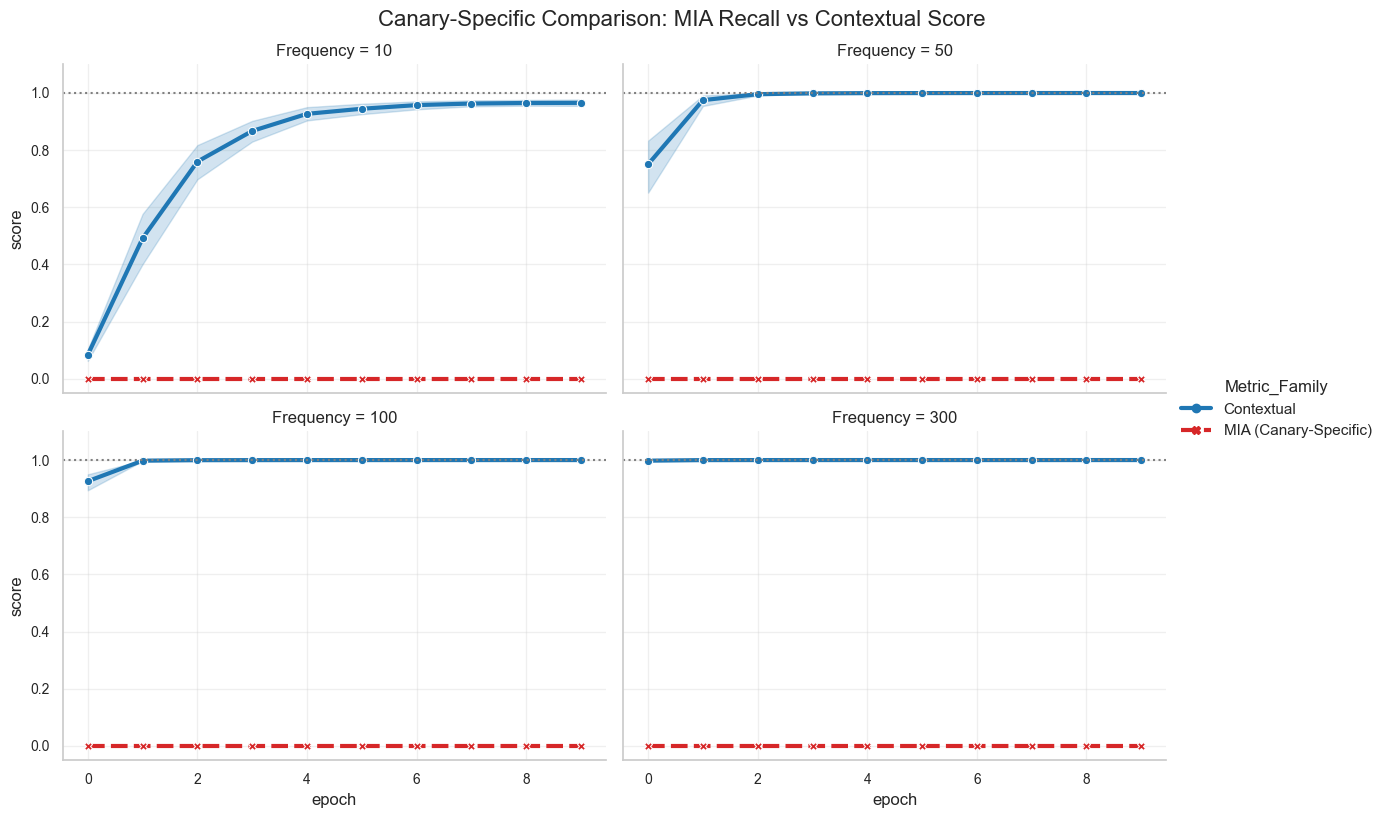

In [32]:

# --- EXECUTE ---
if stdout_file and thresholds:
    print("🚀 Recalculating MIA with Loss Difference Logic...")
    df_mia_canary = calculate_canary_mia(df_mem, thresholds)
    
    # Check if we have non-zero values now
    print(f"   Max MIA Recall found: {df_mia_canary['score'].max()}")
    
    plot_canary_comparison(df_mem, df_mia_canary, loss_type='Suffix')